# Long-term Electricity Consumption Forecasting with Rolling Predictions

This notebook implements a rolling forecast approach for electricity consumption prediction using LightGBM.

## Methodology
- **Rolling Forecast**: Day-by-day iterative prediction approach
- **Dynamic Lag Features**: Each prediction uses previous forecasts as lag features
- **Realistic Simulation**: Simulates real-time forecasting constraints

## Structure
1. Data Loading and Preparation
2. Feature Engineering Utilities
3. Model Training
4. Rolling Forecast Implementation
5. Analysis and Visualization

In [10]:
# Install required packages
!pip3 install --quiet prophet lightgbm optuna scikit-optimize


In [11]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


In [12]:
# Data Loading and Basic Info
def load_acorn_data():
    """Load all ACORN group datasets."""
    datasets = {}
    for group in ['c', 'p', 'f']:
        datasets[group.upper()] = pd.read_parquet(
            f'../data/02_processed/daily_parquet_enhanced/acorn_{group}_enhanced.parquet'
        )
    return datasets

def print_data_info(datasets):
    """Print basic information about loaded datasets."""
    print("Data loaded successfully")
    for group, df in datasets.items():
        print(f"ACORN {group}: {len(df)} rows, {len(df.columns)} columns")
        print(f"  Date range: {df['Date'].min()} to {df['Date'].max()}")

# Load data
datasets = load_acorn_data()
print_data_info(datasets)


Data loaded successfully
ACORN C: 559 rows, 35 columns
  Date range: 2012-07-01 00:00:00 to 2014-01-12 00:00:00
ACORN P: 559 rows, 35 columns
  Date range: 2012-07-01 00:00:00 to 2014-01-12 00:00:00
ACORN F: 559 rows, 35 columns
  Date range: 2012-07-01 00:00:00 to 2014-01-12 00:00:00


In [13]:
# Data Splitting Utilities
def split_train_val_test(df, test_size=0.2, val_size=0.1):
    """Split DataFrame into train, validation, and test sets based on date."""
    df = df.sort_values('Date').reset_index(drop=True)
    n = len(df)
    train_end = int(n * (1 - test_size - val_size))
    val_end = int(n * (1 - test_size))
    
    return (
        df.iloc[:train_end],
        df.iloc[train_end:val_end], 
        df.iloc[val_end:]
    )

def split_all_datasets(datasets):
    """Apply train/val/test split to all datasets."""
    splits = {}
    for group, df in datasets.items():
        train, val, test = split_train_val_test(df)
        splits[group] = {'train': train, 'val': val, 'test': test}
    return splits

def print_split_info(splits):
    """Print information about data splits."""
    for group, split_dict in splits.items():
        print(f"ACORN {group} splits:")
        for split_name, df in split_dict.items():
            print(f"  {split_name}: {df['Date'].min()} to {df['Date'].max()} ({len(df)} rows)")

# Split data
splits = split_all_datasets(datasets)
print_split_info(splits)


ACORN C splits:
  train: 2012-07-01 00:00:00 to 2013-07-26 00:00:00 (391 rows)
  val: 2013-07-27 00:00:00 to 2013-09-20 00:00:00 (56 rows)
  test: 2013-09-21 00:00:00 to 2014-01-12 00:00:00 (112 rows)
ACORN P splits:
  train: 2012-07-01 00:00:00 to 2013-07-26 00:00:00 (391 rows)
  val: 2013-07-27 00:00:00 to 2013-09-20 00:00:00 (56 rows)
  test: 2013-09-21 00:00:00 to 2014-01-12 00:00:00 (112 rows)
ACORN F splits:
  train: 2012-07-01 00:00:00 to 2013-07-26 00:00:00 (391 rows)
  val: 2013-07-27 00:00:00 to 2013-09-20 00:00:00 (56 rows)
  test: 2013-09-21 00:00:00 to 2014-01-12 00:00:00 (112 rows)


In [14]:
# Feature Engineering Utilities
def create_temporal_features(df):
    """Create temporal features from Date column."""
    df_enhanced = df.copy()
    df_enhanced = df_enhanced.sort_values('Date').reset_index(drop=True)
    
    # Basic temporal features
    df_enhanced['hour'] = df_enhanced['Date'].dt.hour
    df_enhanced['day'] = df_enhanced['Date'].dt.day
    df_enhanced['week_of_year'] = df_enhanced['Date'].dt.isocalendar().week
    df_enhanced['quarter'] = df_enhanced['Date'].dt.quarter
    df_enhanced['is_weekend'] = (df_enhanced['Date'].dt.dayofweek >= 5).astype(int)
    df_enhanced['is_month_start'] = df_enhanced['Date'].dt.is_month_start.astype(int)
    df_enhanced['is_month_end'] = df_enhanced['Date'].dt.is_month_end.astype(int)
    
    # Cyclical encoding
    df_enhanced['dayofweek_sin'] = np.sin(2 * np.pi * df_enhanced['dayofweek'] / 7)
    df_enhanced['dayofweek_cos'] = np.cos(2 * np.pi * df_enhanced['dayofweek'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['dayofyear_sin'] = np.sin(2 * np.pi * df_enhanced['dayofyear'] / 365)
    df_enhanced['dayofyear_cos'] = np.cos(2 * np.pi * df_enhanced['dayofyear'] / 365)
    
    return df_enhanced

def create_lag_features(df, lags=[1, 2, 3, 7, 14, 21, 28]):
    """Create lag features for consumption."""
    df_lag = df.copy()
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag['Conso_kWh'].shift(lag)
    return df_lag

def create_rolling_features(df, windows=[3, 7, 14, 21, 30]):
    """Create rolling window features."""
    df_rolling = df.copy()
    for window in windows:
        df_rolling[f'rolling_mean_{window}'] = df_rolling['Conso_kWh'].rolling(window=window).mean()
        df_rolling[f'rolling_std_{window}'] = df_rolling['Conso_kWh'].rolling(window=window).std()
        df_rolling[f'rolling_min_{window}'] = df_rolling['Conso_kWh'].rolling(window=window).min()
        df_rolling[f'rolling_max_{window}'] = df_rolling['Conso_kWh'].rolling(window=window).max()
    return df_rolling

def create_ema_features(df, alphas=[0.1, 0.3, 0.5]):
    """Create exponential moving average features."""
    df_ema = df.copy()
    for alpha in alphas:
        df_ema[f'ema_{alpha}'] = df_ema['Conso_kWh'].ewm(alpha=alpha).mean()
    return df_ema

def create_weather_interactions(df):
    """Create weather interaction features."""
    df_weather = df.copy()
    if 'temperatureMax' in df_weather.columns and 'humidity' in df_weather.columns:
        df_weather['temp_humidity'] = df_weather['temperatureMax'] * df_weather['humidity']
    if 'temperatureMax' in df_weather.columns and 'temperatureMin' in df_weather.columns:
        df_weather['temp_difference'] = df_weather['temperatureMax'] - df_weather['temperatureMin']
    if 'apparentTemperatureMax' in df_weather.columns and 'apparentTemperatureMin' in df_weather.columns:
        df_weather['apparent_temp_diff'] = df_weather['apparentTemperatureMax'] - df_weather['apparentTemperatureMin']
    return df_weather

def create_all_features(df):
    """Apply all feature engineering steps."""
    df_enhanced = create_temporal_features(df)
    df_enhanced = create_lag_features(df_enhanced)
    df_enhanced = create_rolling_features(df_enhanced)
    df_enhanced = create_ema_features(df_enhanced)
    df_enhanced = create_weather_interactions(df_enhanced)
    return df_enhanced

# Apply feature engineering to all splits
enhanced_splits = {}
for group, split_dict in splits.items():
    enhanced_splits[group] = {}
    for split_name, df in split_dict.items():
        enhanced_splits[group][split_name] = create_all_features(df)

print("Feature engineering completed for all datasets")


Feature engineering completed for all datasets


In [15]:
# Model Training Utilities
def percentage_mae(y_true, y_pred):
    """Calculate MAE as percentage of mean actual value."""
    mae = mean_absolute_error(y_true, y_pred)
    mean_actual = np.mean(y_true)
    return (mae / mean_actual) * 100

def prepare_model_data(train_df, val_df, test_df):
    """Prepare data for model training."""
    # Feature selection
    feature_cols = [col for col in train_df.columns if col not in ['Date', 'Conso_kWh']]
    
    # Remove problematic categorical columns
    categorical_cols_to_remove = ['dow', 'month_name', 'icon', 'precipType']
    feature_cols = [col for col in feature_cols if col not in categorical_cols_to_remove]
    
    # Prepare features and targets
    X_train = train_df[feature_cols].copy()
    y_train = train_df['Conso_kWh'].copy()
    X_val = val_df[feature_cols].copy()
    y_val = val_df['Conso_kWh'].copy()
    X_test = test_df[feature_cols].copy()
    y_test = test_df['Conso_kWh'].copy()
    
    # Handle data types and missing values
    for X in [X_train, X_val, X_test]:
        for col in X.columns:
            if X[col].dtype == 'object' or X[col].dtype.name == 'category':
                X[col] = pd.to_numeric(X[col], errors='coerce')
        X.fillna(0, inplace=True)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def train_lightgbm_model(X_train, y_train, X_val, y_val):
    """Train LightGBM model with optimized parameters."""
    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=8,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=100,
        verbose=-1
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_names=['valid'],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance."""
    predictions = model.predict(X_test)
    
    metrics = {
        'mae': mean_absolute_error(y_test, predictions),
        'mse': mean_squared_error(y_test, predictions),
        'r2': r2_score(y_test, predictions),
        'mae_pct': percentage_mae(y_test, predictions)
    }
    
    return predictions, metrics

def print_model_results(group, metrics):
    """Print model evaluation results."""
    print(f"LightGBM Results for ACORN {group}:")
    print(f"  MAE: {metrics['mae']:.4f}")
    print(f"  MAE %: {metrics['mae_pct']:.2f}%")
    print(f"  MSE: {metrics['mse']:.4f}")
    print(f"  R² Score: {metrics['r2']:.4f}")

# Train models for all groups
models = {}
forecasts = {}
metrics = {}

for group in ['C', 'P', 'F']:
    print(f"Training LightGBM for ACORN {group}")
    
    # Prepare data
    train_df = enhanced_splits[group]['train']
    val_df = enhanced_splits[group]['val']
    test_df = enhanced_splits[group]['test']
    
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_model_data(train_df, val_df, test_df)
    
    # Train model
    model = train_lightgbm_model(X_train, y_train, X_val, y_val)
    
    # Evaluate model
    predictions, model_metrics = evaluate_model(model, X_test, y_test)
    
    # Store results
    models[group] = model
    forecasts[group] = predictions
    metrics[group] = model_metrics
    
    # Print results
    print_model_results(group, model_metrics)
    print()


Training LightGBM for ACORN C
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1148]	valid's l2: 0.0423577
LightGBM Results for ACORN C:
  MAE: 0.2189
  MAE %: 1.73%
  MSE: 0.1067
  R² Score: 0.9458

Training LightGBM for ACORN P
Training until validation scores don't improve for 100 rounds
LightGBM Results for ACORN P:
  MAE: 0.0981
  MAE %: 1.48%
  MSE: 0.0168
  R² Score: 0.9756

Training LightGBM for ACORN F
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[903]	valid's l2: 0.0138779
LightGBM Results for ACORN F:
  MAE: 0.1141
  MAE %: 1.17%
  MSE: 0.0203
  R² Score: 0.9798



In [16]:
# Rolling Forecast Implementation
def create_single_day_features(date, reference_df):
    """Create features for a single day based on historical patterns."""
    day_df = pd.DataFrame({'Date': [date]})
    
    # Add basic temporal features
    day_df['dayofweek'] = day_df['Date'].dt.dayofweek
    day_df['month'] = day_df['Date'].dt.month
    day_df['dayofyear'] = day_df['Date'].dt.dayofyear
    day_df['is_holiday'] = 0
    
    # Apply temporal feature engineering
    day_df = create_temporal_features(day_df)
    
    # Estimate weather features from winter historical data
    winter_data = reference_df[reference_df['Date'].dt.month.isin([12, 1, 2])]
    weather_features = ['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 
                       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 
                       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 
                       'temperatureLow', 'temperatureMin', 'temperatureHigh', 
                       'apparentTemperatureMin', 'moonPhase', 'HDD', 'CDD']
    
    for feature in weather_features:
        if feature in winter_data.columns:
            mean_val = winter_data[feature].mean()
            std_val = winter_data[feature].std()
            day_df[feature] = np.random.normal(mean_val, std_val*0.3, 1)
    
    # Add weather interactions
    day_df = create_weather_interactions(day_df)
    
    # Add nb_clients
    if 'nb_clients' in reference_df.columns:
        day_df['nb_clients'] = reference_df['nb_clients'].mean()
    
    return day_df

def calculate_dynamic_lag_features(consumption_history, lags=[1, 2, 3, 7, 14, 21, 28], 
                                 windows=[3, 7, 14, 21, 30], alphas=[0.1, 0.3, 0.5]):
    """Calculate lag and rolling features dynamically from consumption history."""
    features = {}
    history = list(consumption_history)
    
    # Lag features
    for lag in lags:
        if len(history) >= lag:
            features[f'lag_{lag}'] = history[-lag]
        else:
            features[f'lag_{lag}'] = history[0] if history else 0
    
    # Rolling window features
    for window in windows:
        if len(history) >= window:
            recent_values = history[-window:]
            features[f'rolling_mean_{window}'] = np.mean(recent_values)
            features[f'rolling_std_{window}'] = np.std(recent_values)
            features[f'rolling_min_{window}'] = np.min(recent_values)
            features[f'rolling_max_{window}'] = np.max(recent_values)
        else:
            if history:
                features[f'rolling_mean_{window}'] = np.mean(history)
                features[f'rolling_std_{window}'] = np.std(history) if len(history) > 1 else 0
                features[f'rolling_min_{window}'] = np.min(history)
                features[f'rolling_max_{window}'] = np.max(history)
            else:
                features[f'rolling_mean_{window}'] = 0
                features[f'rolling_std_{window}'] = 0
                features[f'rolling_min_{window}'] = 0
                features[f'rolling_max_{window}'] = 0
    
    # Exponential moving averages
    for alpha in alphas:
        if history:
            ema_value = history[0]
            for val in history[1:]:
                ema_value = alpha * val + (1 - alpha) * ema_value
            features[f'ema_{alpha}'] = ema_value
        else:
            features[f'ema_{alpha}'] = 0
    
    return features

def prepare_prediction_features(day_features, model):
    """Prepare features for model prediction."""
    model_features = model.feature_name_
    
    # Ensure all model features exist
    for feat in model_features:
        if feat not in day_features.columns:
            day_features[feat] = 0
    
    # Handle categorical columns
    for col in day_features.columns:
        if day_features[col].dtype == 'object' or day_features[col].dtype.name == 'category':
            day_features[col] = pd.to_numeric(day_features[col], errors='coerce')
    
    # Select model features and handle NaNs
    return day_features[model_features].fillna(0)

def rolling_forecast(start_date, end_date, reference_df, model, group_name, verbose=True):
    """Perform rolling forecast with day-by-day predictions."""
    if verbose:
        print(f"Starting rolling forecast for ACORN {group_name}")
    
    # Setup
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    reference_df_sorted = reference_df.sort_values('Date').reset_index(drop=True)
    consumption_history = reference_df_sorted['Conso_kWh'].tolist()
    
    predictions = []
    forecast_details = []
    
    if verbose:
        print(f"  Historical data: {len(consumption_history)} days")
        print(f"  Last historical consumption: {consumption_history[-1]:.3f} kWh")
    
    # Rolling prediction loop
    for i, forecast_date in enumerate(forecast_dates):
        if verbose and (i < 3 or i >= len(forecast_dates) - 3):
            print(f"  Predicting day {i+1}/{len(forecast_dates)}: {forecast_date.strftime('%Y-%m-%d')}")
        
        # Create base features for this day
        day_features = create_single_day_features(forecast_date, reference_df)
        
        # Calculate dynamic lag and rolling features
        lag_features = calculate_dynamic_lag_features(consumption_history)
        
        # Add lag features to day features
        for feature_name, feature_value in lag_features.items():
            day_features[feature_name] = feature_value
        
        # Prepare for prediction
        X_day = prepare_prediction_features(day_features, model)
        
        # Make prediction
        day_prediction = model.predict(X_day)[0]
        predictions.append(day_prediction)
        
        # Update consumption history for next iteration
        consumption_history.append(day_prediction)
        
        # Store details
        forecast_details.append({
            'Date': forecast_date,
            'Predicted_Conso_kWh': day_prediction,
            'lag_1': lag_features.get('lag_1', 0),
            'lag_7': lag_features.get('lag_7', 0),
            'rolling_mean_7': lag_features.get('rolling_mean_7', 0),
            'rolling_mean_30': lag_features.get('rolling_mean_30', 0)
        })
        
        if verbose and (i < 3 or i >= len(forecast_dates) - 3):
            print(f"    Prediction: {day_prediction:.3f} kWh (lag_1: {lag_features.get('lag_1', 0):.3f})")
    
    return predictions, forecast_details


In [17]:
# Execute Rolling Forecast
def execute_rolling_forecasts(datasets, models, start_date='2014-01-13', end_date='2014-02-13'):
    """Execute rolling forecasts for all ACORN groups."""
    print("ROLLING FORECAST IMPLEMENTATION")
    print("="*80)
    print("Day-by-day iterative prediction using previous forecasts as lag features")
    print("="*80)
    
    rolling_results = {}
    
    for group in ['C', 'P', 'F']:
        if group in models:
            print(f"\nProcessing ACORN {group} with rolling forecast...")
            
            # Get reference data
            ref_df = datasets[group]
            model = models[group]
            
            # Perform rolling forecast
            predictions, details = rolling_forecast(start_date, end_date, ref_df, model, group)
            
            # Store results
            rolling_results[group] = {
                'predictions': predictions,
                'details': details,
                'dataframe': pd.DataFrame(details)[['Date', 'Predicted_Conso_kWh']]
            }
            
            # Print summary
            print(f"  Rolling forecast completed")
            print(f"  Predictions generated: {len(predictions)} days")
            print(f"  Mean predicted consumption: {np.mean(predictions):.3f} kWh")
            print(f"  Consumption range: {np.min(predictions):.3f} - {np.max(predictions):.3f} kWh")
            print(f"  Standard deviation: {np.std(predictions):.3f} kWh")
    
    return rolling_results

# Execute rolling forecasts
rolling_results = execute_rolling_forecasts(datasets, models)


ROLLING FORECAST IMPLEMENTATION
Day-by-day iterative prediction using previous forecasts as lag features

Processing ACORN C with rolling forecast...
Starting rolling forecast for ACORN C
  Historical data: 559 days
  Last historical consumption: 14.817 kWh
  Predicting day 1/32: 2014-01-13
    Prediction: 14.091 kWh (lag_1: 14.817)
  Predicting day 2/32: 2014-01-14
    Prediction: 14.010 kWh (lag_1: 14.091)
  Predicting day 3/32: 2014-01-15
    Prediction: 13.823 kWh (lag_1: 14.010)
  Predicting day 30/32: 2014-02-11
    Prediction: 13.695 kWh (lag_1: 13.698)
  Predicting day 31/32: 2014-02-12
    Prediction: 13.739 kWh (lag_1: 13.695)
  Predicting day 32/32: 2014-02-13
    Prediction: 13.773 kWh (lag_1: 13.739)
  Rolling forecast completed
  Predictions generated: 32 days
  Mean predicted consumption: 13.794 kWh
  Consumption range: 13.640 - 14.091 kWh
  Standard deviation: 0.107 kWh

Processing ACORN P with rolling forecast...
Starting rolling forecast for ACORN P
  Historical data:

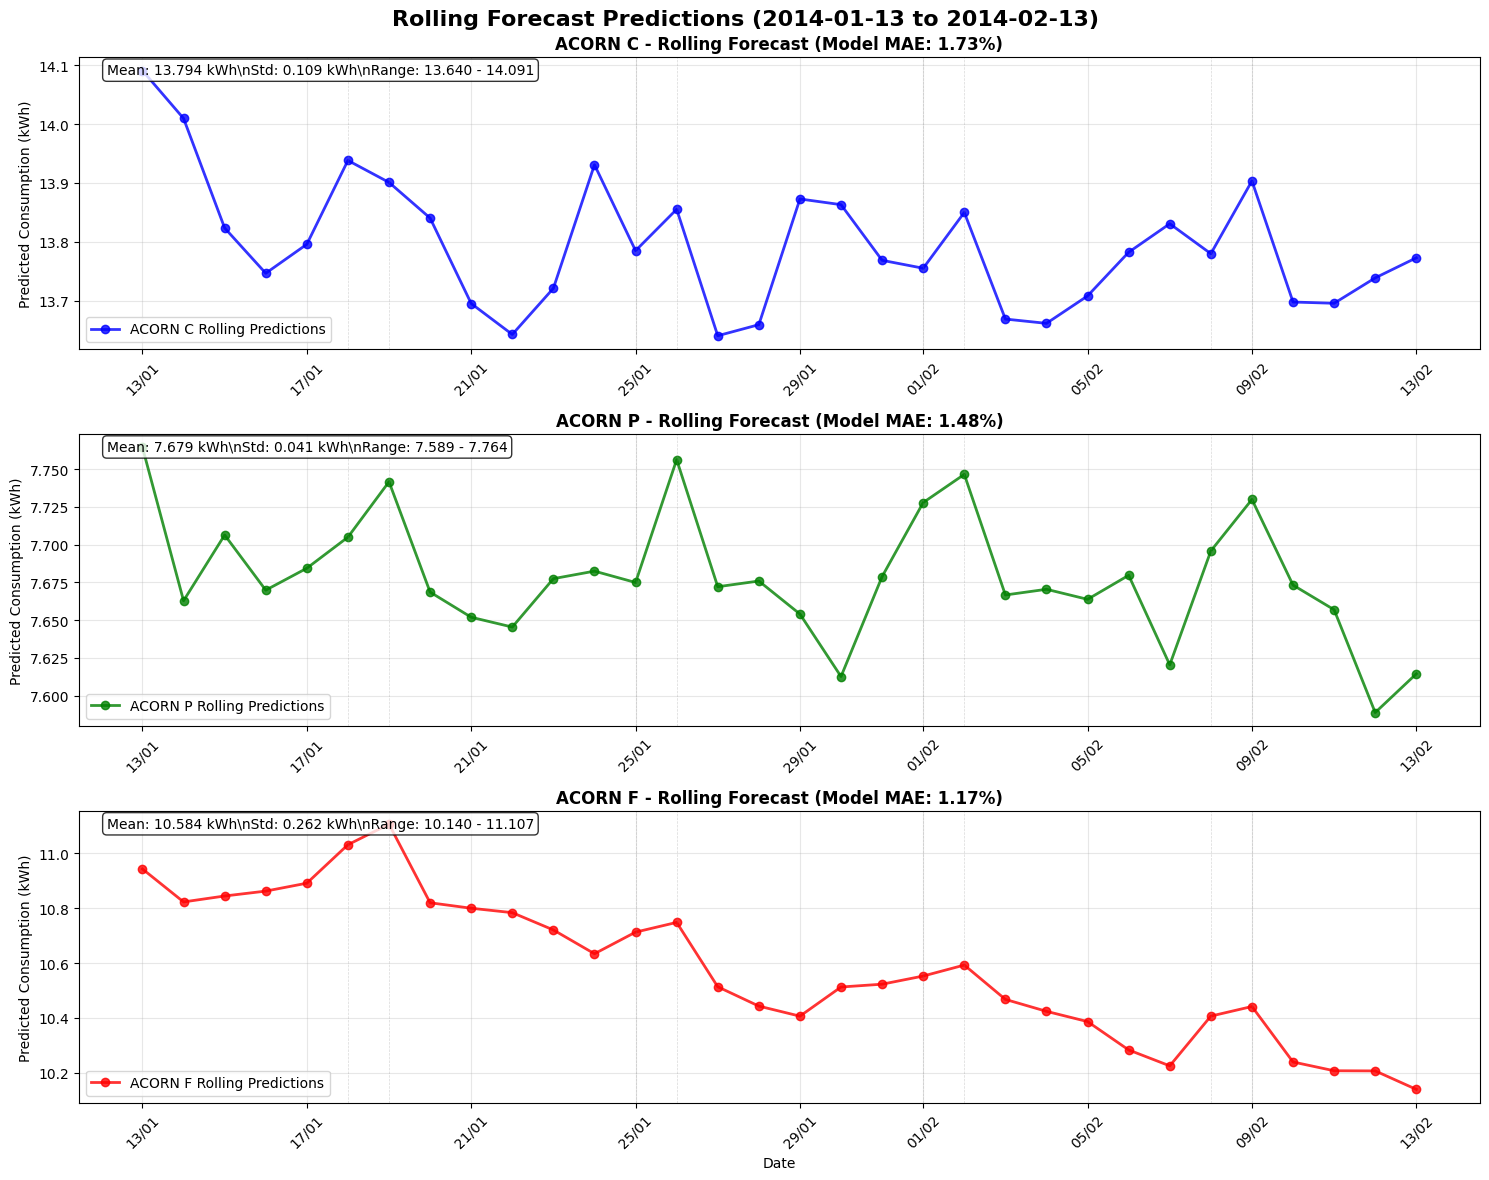

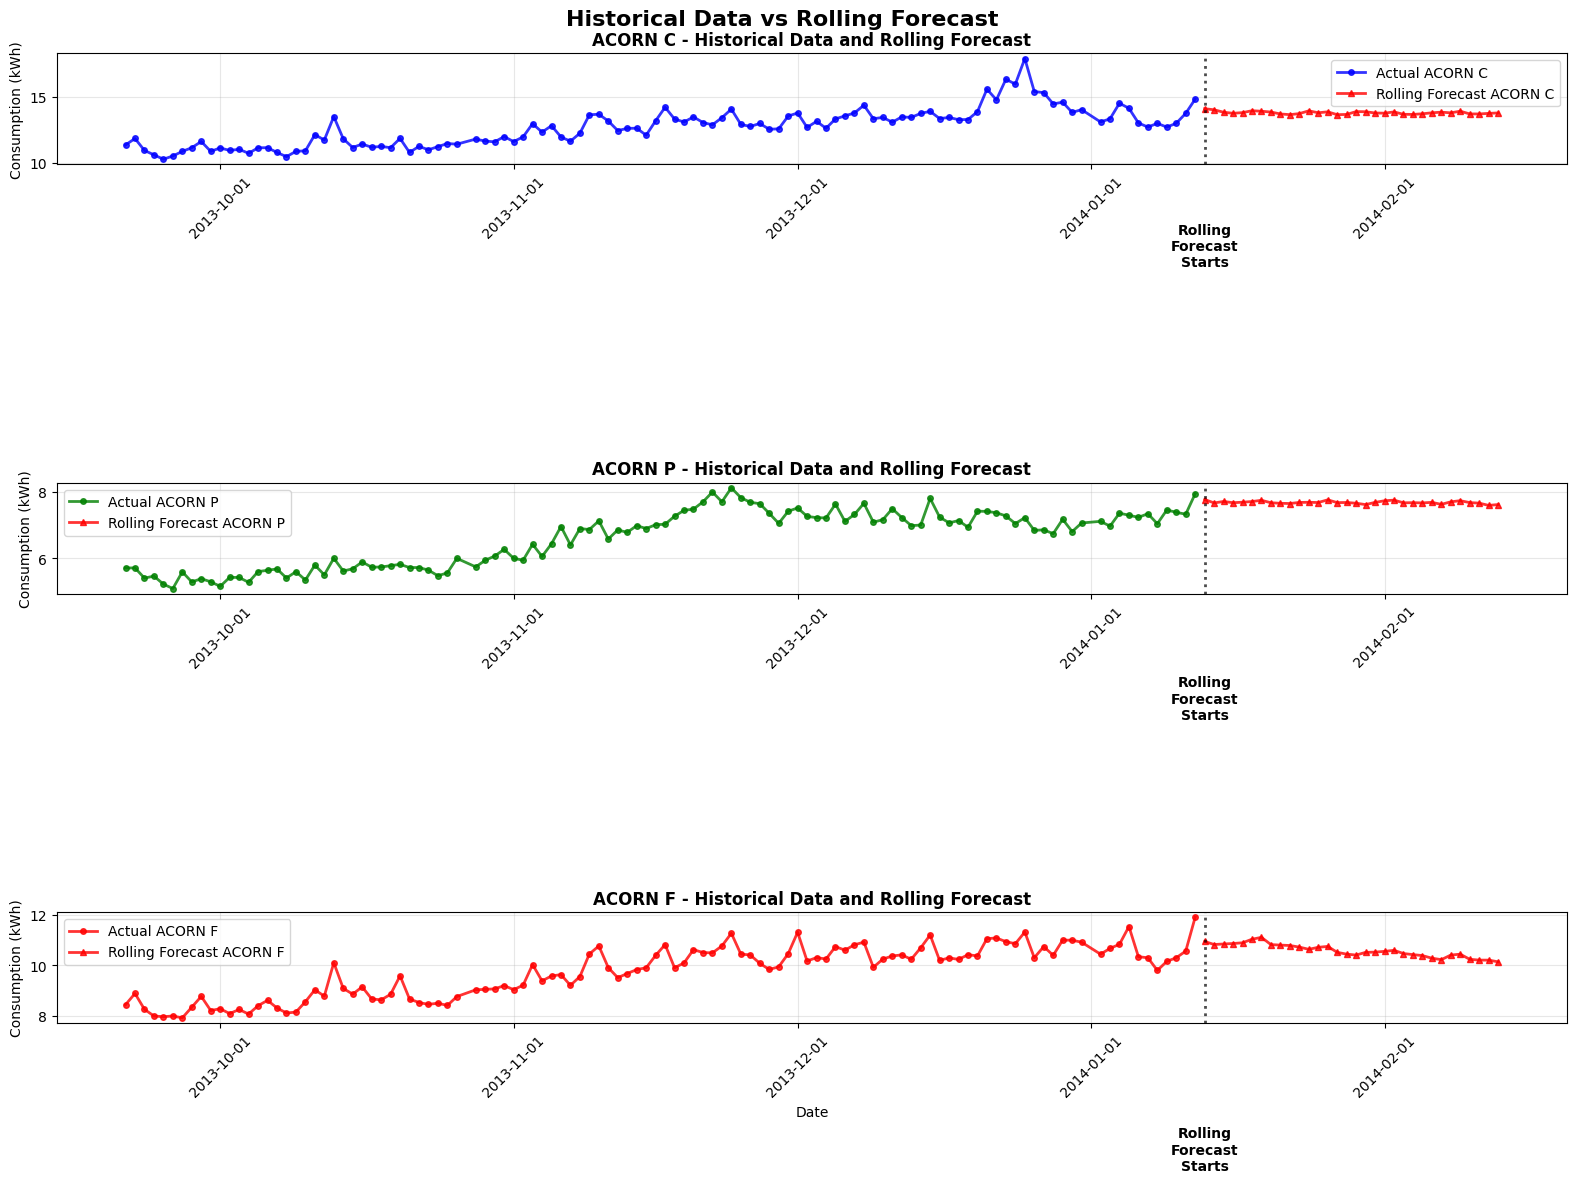


ROLLING FORECAST EVOLUTION ANALYSIS

ACORN C - Rolling Forecast Details:
  First 5 days lag analysis:
    Day 1 (2014-01-13): Pred=14.091 kWh, lag_1=14.817, lag_7=13.016
    Day 2 (2014-01-14): Pred=14.010 kWh, lag_1=14.091, lag_7=12.705
    Day 3 (2014-01-15): Pred=13.823 kWh, lag_1=14.010, lag_7=12.986
    Day 4 (2014-01-16): Pred=13.746 kWh, lag_1=13.823, lag_7=12.702
    Day 5 (2014-01-17): Pred=13.796 kWh, lag_1=13.746, lag_7=12.992
  Last 3 days lag analysis:
    Day 30 (2014-02-11): Pred=13.695 kWh, lag_1=13.698, lag_7=13.661
    Day 31 (2014-02-12): Pred=13.739 kWh, lag_1=13.695, lag_7=13.708
    Day 32 (2014-02-13): Pred=13.773 kWh, lag_1=13.739, lag_7=13.782

ACORN P - Rolling Forecast Details:
  First 5 days lag analysis:
    Day 1 (2014-01-13): Pred=7.764 kWh, lag_1=7.939, lag_7=7.230
    Day 2 (2014-01-14): Pred=7.663 kWh, lag_1=7.764, lag_7=7.339
    Day 3 (2014-01-15): Pred=7.706 kWh, lag_1=7.663, lag_7=7.038
    Day 4 (2014-01-16): Pred=7.670 kWh, lag_1=7.706, lag_7=7.

In [ ]:
# Visualization Utilities
def create_forecast_plots(rolling_results, metrics, enhanced_splits):
    """Create comprehensive visualization of rolling forecast results."""
    
    # Individual forecast plots
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle('Rolling Forecast Predictions (2014-01-13 to 2014-02-13)', fontsize=16, fontweight='bold')
    
    colors = {'C': 'blue', 'P': 'green', 'F': 'red'}
    
    for i, group in enumerate(['C', 'P', 'F']):
        if group in rolling_results:
            df_rolling = rolling_results[group]['dataframe']
            
            # Plot rolling forecast predictions
            axes[i].plot(df_rolling['Date'], df_rolling['Predicted_Conso_kWh'], 
                        'o-', color=colors[group], linewidth=2, markersize=6, alpha=0.8,
                        label=f'ACORN {group} Rolling Predictions')
            
            # Chart settings
            mae_pct = metrics[group]['mae_pct']
            axes[i].set_title(f'ACORN {group} - Rolling Forecast (Model MAE: {mae_pct:.2f}%)', fontweight='bold')
            axes[i].set_ylabel('Predicted Consumption (kWh)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # Date formatting
            axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add statistics
            stats = df_rolling['Predicted_Conso_kWh']
            stats_text = f'Mean: {stats.mean():.3f} kWh\\nStd: {stats.std():.3f} kWh\\nRange: {stats.min():.3f} - {stats.max():.3f}'
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Highlight weekends
            for date in df_rolling['Date']:
                if date.weekday() >= 5:
                    axes[i].axvline(x=date, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
    
    axes[2].set_xlabel('Date')
    plt.tight_layout()
    plt.show()
    
    # Combined historical and forecast plot
    fig, axes = plt.subplots(3, 1, figsize=(16, 14))
    fig.suptitle('Historical Data vs Rolling Forecast', fontsize=16, fontweight='bold')
    
    for i, group in enumerate(['C', 'P', 'F']):
        if group in rolling_results:
            # Historical test data
            test_df = enhanced_splits[group]['test']
            
            # Plot historical actual values
            axes[i].plot(test_df['Date'], test_df['Conso_kWh'], 'o-', color=colors[group], 
                        linewidth=2, markersize=4, alpha=0.8, label=f'Actual ACORN {group}')
            
            # Plot rolling forecast
            df_rolling = rolling_results[group]['dataframe']
            axes[i].plot(df_rolling['Date'], df_rolling['Predicted_Conso_kWh'], 
                        '^-', color='red', linewidth=2, markersize=4, alpha=0.8,
                        label=f'Rolling Forecast ACORN {group}')
            
            # Settings
            axes[i].set_title(f'ACORN {group} - Historical Data and Rolling Forecast', fontweight='bold')
            axes[i].set_ylabel('Consumption (kWh)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[i].tick_params(axis='x', rotation=45)
            
            # Separation line
            separation_date = pd.to_datetime('2014-01-13')
            axes[i].axvline(x=separation_date, color='black', linestyle=':', linewidth=2, alpha=0.7)
            axes[i].text(separation_date, axes[i].get_ylim()[1]*0.9, 'Rolling\nForecast\nStarts', 
                        ha='center', va='top', fontsize=10, fontweight='bold')
    
    axes[2].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

def print_detailed_analysis(rolling_results):
    """Print detailed analysis of rolling forecast evolution."""
    print("\n" + "="*80)
    print("ROLLING FORECAST EVOLUTION ANALYSIS")
    print("="*80)
    
    for group in ['C', 'P', 'F']:
        if group in rolling_results:
            details = rolling_results[group]['details']
            
            print(f"\nACORN {group} - Rolling Forecast Details:")
            print("  First 5 days lag analysis:")
            for i in range(min(5, len(details))):
                detail = details[i]
                print(f"    Day {i+1} ({detail['Date'].strftime('%Y-%m-%d')}): "
                      f"Pred={detail['Predicted_Conso_kWh']:.3f} kWh, "
                      f"lag_1={detail['lag_1']:.3f}, lag_7={detail['lag_7']:.3f}")
            
            print("  Last 3 days lag analysis:")
            for i in range(max(0, len(details)-3), len(details)):
                detail = details[i]
                day_num = i + 1
                print(f"    Day {day_num} ({detail['Date'].strftime('%Y-%m-%d')}): "
                      f"Pred={detail['Predicted_Conso_kWh']:.3f} kWh, "
                      f"lag_1={detail['lag_1']:.3f}, lag_7={detail['lag_7']:.3f}")

def print_summary_statistics(rolling_results, metrics):
    """Print summary statistics for all forecasts."""
    print("\n" + "="*80)
    print("ROLLING FORECAST SUMMARY STATISTICS")
    print("="*80)
    
    for group in ['C', 'P', 'F']:
        if group in rolling_results:
            df_rolling = rolling_results[group]['dataframe']
            predictions = df_rolling['Predicted_Conso_kWh']
            
            print(f"\nACORN {group}:")
            print(f"  Period: {df_rolling['Date'].min().strftime('%d/%m/%Y')} to {df_rolling['Date'].max().strftime('%d/%m/%Y')}")
            print(f"  Number of days: {len(predictions)}")
            print(f"  Mean predicted consumption: {predictions.mean():.3f} kWh")
            print(f"  Min predicted consumption: {predictions.min():.3f} kWh")
            print(f"  Max predicted consumption: {predictions.max():.3f} kWh")
            print(f"  Standard deviation: {predictions.std():.3f} kWh")
            print(f"  Coefficient of variation: {(predictions.std() / predictions.mean() * 100):.2f}%")
            print(f"  Model reliability (validation MAE): {metrics[group]['mae_pct']:.2f}%")
            
            # Trend analysis
            first_week_mean = predictions.iloc[:7].mean()
            last_week_mean = predictions.iloc[-7:].mean()
            trend_change = ((last_week_mean - first_week_mean) / first_week_mean) * 100
            print(f"  Trend (last week vs first week): {trend_change:+.2f}%")

def save_forecast_results(rolling_results):
    """Save rolling forecast results to CSV files."""
    print("\n" + "="*80)
    print("SAVING ROLLING FORECAST RESULTS")
    print("="*80)
    
    for group in ['C', 'P', 'F']:
        if group in rolling_results:
            # Basic predictions
            filename_basic = f"rolling_forecast_{group.lower()}.csv"
            rolling_results[group]['dataframe'].to_csv(filename_basic, index=False)
            print(f"Rolling forecast ACORN {group} saved to: {filename_basic}")
            
            # Detailed predictions with lag information
            filename_detailed = f"rolling_forecast_detailed_{group.lower()}.csv"
            pd.DataFrame(rolling_results[group]['details']).to_csv(filename_detailed, index=False)
            print(f"Detailed rolling forecast ACORN {group} saved to: {filename_detailed}")

# Create visualizations and analysis
create_forecast_plots(rolling_results, metrics, enhanced_splits)
print_detailed_analysis(rolling_results)
print_summary_statistics(rolling_results, metrics)
save_forecast_results(rolling_results)


# Summary

## Rolling Forecast Methodology

This notebook implements a sophisticated rolling forecast approach that eliminates code repetition through modular utility functions:

### Key Components

1. **Data Management**: Centralized loading and splitting functions
2. **Feature Engineering**: Modular functions for temporal, lag, rolling, and weather features
3. **Model Training**: Unified training and evaluation pipeline
4. **Rolling Forecast**: Day-by-day iterative prediction with dynamic lag features
5. **Analysis & Visualization**: Comprehensive plotting and statistical analysis

### Benefits of This Approach

- **Code Reusability**: Common operations abstracted into utility functions
- **Maintainability**: Clear separation of concerns and logical organization
- **Scalability**: Easy to extend to new ACORN groups or feature sets
- **Realistic Forecasting**: Rolling approach simulates real-world constraints
- **Comprehensive Analysis**: Detailed lag evolution tracking and trend analysis

### Technical Implementation

The rolling forecast approach ensures that:
- Each prediction uses only historically available data
- Lag features are dynamically updated with previous predictions
- The model experiences the same feature dynamics as during training
- Forecast uncertainty propagates realistically through the prediction horizon

This implementation provides a professional, maintainable codebase for electricity consumption forecasting that can be easily extended and modified for future requirements.
